## 1. Setup & Configuration

In [1]:
import os
import sys
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, Dense, Dropout, Add, Bidirectional, LSTM, MaxPooling1D
from tensorflow.keras.regularizers import l2

In [2]:
# 프로젝트 루트 경로 설정
PROJECT_ROOT = '/content/drive/MyDrive/Colab Notebooks/HAR_Research_Project'
sys.path.append(PROJECT_ROOT)

In [3]:
# utils.py 로드
from utils import (
    squeeze_excite_block, cbam_block, transformer_encoder, categorical_focal_loss,
    spatial_shape, cbam_reduce_mean, cbam_reduce_max # [추가]
)

### 1.1. 실험마다 변경할 변수들

In [4]:
# 1. 데이터셋: 'UCI', 'WISDM', 'UniMiB', 'PAMAP2', 'Opportunity'
TARGET_DATASET = 'UCI'

# 2. 모델: 'standard_resnet', 'cnn_bilstm', 'se_resnet', 'cbam_resnet', 'resnet_transformer'
TARGET_MODEL = 'cbam_resnet'

# 3. 실험 태그 (파일명 중복 방지용) - 날짜 또는 실험 특징 기입
EXPERIMENT_TAG = '20251204'

# 4. 하이퍼파라미터
EPOCHS = 150
BATCH_SIZE = 64
LEARNING_RATE = 0.0005

# 파일 ID 생성 (자동)
FILE_ID = f"{TARGET_DATASET}_{TARGET_MODEL}_{EXPERIMENT_TAG}"
print(f"🚀 Experiment Initialized: {FILE_ID}")

🚀 Experiment Initialized: UCI_cbam_resnet_20251204


## 2. Data Loading & Preprocessing

In [5]:
def load_dataset_fixed(name):
    print(f"\n[Data Loading] {name} 데이터셋 로드 중 (Fixed Split)...")
    data_dir = f'{PROJECT_ROOT}/data/processed'

    # 1. 고정된 Train/Test 파일 로드
    try:
        X_train = np.load(f'{data_dir}/{name}_X_train.npy')
        y_train = np.load(f'{data_dir}/{name}_y_train.npy')
        X_test  = np.load(f'{data_dir}/{name}_X_test.npy')
        y_test  = np.load(f'{data_dir}/{name}_y_test.npy')
    except FileNotFoundError:
        # 파일이 분리 안 되어 있는 경우(다른 데이터셋) 기존 방식 사용
        print(f"⚠️ 분리된 파일이 없습니다. 기존 통합 로드 방식으로 전환합니다.")
        return load_dataset_random(name) # 기존 함수 호출 (코드 아래에 유지 필요)

    # 2. Validation Set 생성 (Train 데이터의 20%를 떼어서 사용)
    # Test Set은 절대 건드리지 않음
    n_classes = len(np.unique(y_train))
    y_train_hot = tf.keras.utils.to_categorical(y_train, n_classes)
    y_test_hot  = tf.keras.utils.to_categorical(y_test, n_classes)

    # Train 내에서만 Val 분리 (stratify 적용)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train_hot, test_size=0.2, random_state=42, stratify=y_train
    )

    return X_train, y_train, X_val, y_val, X_test, y_test_hot, n_classes

In [6]:
def load_dataset_random(name):
    print(f"\n[Data Loading] {name} 데이터셋 로드 중...")
    data_dir = f'{PROJECT_ROOT}/data/processed'

    try:
        X = np.load(f'{data_dir}/{name}_X.npy')
        y = np.load(f'{data_dir}/{name}_y.npy')
    except FileNotFoundError:
        raise FileNotFoundError(f"❌ 파일을 찾을 수 없습니다. {data_dir} 확인 필요.")

    # [Safety] 극소수 클래스 필터링 (Stratify 에러 방지)
    unique, counts = np.unique(y, return_counts=True)
    if np.min(counts) < 5:
        print("⚠️ 극소수 샘플 클래스 제거 중...")
        mask = np.isin(y, unique[counts >= 5])
        X, y = X[mask], y[mask]
        # 라벨 리매핑
        label_map = {old: new for new, old in enumerate(np.unique(y))}
        y = np.vectorize(label_map.get)(y)

    # One-hot Encoding
    n_classes = len(np.unique(y))
    y_cat = tf.keras.utils.to_categorical(y, n_classes)

    # Train/Val/Test Split (6:2:2) with Error Handling
    try:
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y_cat, test_size=0.4, random_state=42, stratify=y
        )
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=42, stratify=np.argmax(y_temp, axis=1)
        )
    except ValueError:
        print("⚠️ Stratify failed (Data imbalance). Switching to random split.")
        X_train, X_temp, y_train, y_temp = train_test_split(X, y_cat, test_size=0.4, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    return X_train, y_train, X_val, y_val, X_test, y_test, n_classes

In [7]:
if TARGET_DATASET == 'UCI':
    # UCI는 파일이 분리되어 있으므로 Fixed 함수 호출
    X_train, y_train, X_val, y_val, X_test, y_test, n_classes = load_dataset_fixed(TARGET_DATASET)
else:
    # 나머지는 아직 파일 분리를 안 했으므로 Random 함수 호출
    X_train, y_train, X_val, y_val, X_test, y_test, n_classes = load_dataset_random(TARGET_DATASET)


[Data Loading] UCI 데이터셋 로드 중 (Fixed Split)...


In [8]:
scaler = StandardScaler()

N_train, T, F = X_train.shape
X_train_2d = X_train.reshape(-1, F)

# Train 데이터로만 fit (Data Leakage 방지)
scaler.fit(X_train_2d)

X_train = scaler.transform(X_train_2d).reshape(X_train.shape)
X_val   = scaler.transform(X_val.reshape(-1, F)).reshape(X_val.shape)
X_test  = scaler.transform(X_test.reshape(-1, F)).reshape(X_test.shape)

print(f"✅ Data Ready: Train={X_train.shape}, Val={X_val.shape}, Test={X_test.shape}")
print(f"Preprocessing Info: Window Size={T}, Channels={F}, No Augmentation")

✅ Data Ready: Train=(5881, 128, 9), Val=(1471, 128, 9), Test=(2947, 128, 9)
Preprocessing Info: Window Size=128, Channels=9, No Augmentation


## 3. Model Architecture Builder

In [9]:
def resnet_block(inputs, filters, stride=1, attention=None):
    shortcut = inputs
    if stride > 1 or inputs.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, strides=stride, padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)

    x = Conv1D(filters, 3, strides=stride, padding='same', kernel_regularizer=l2(5e-5))(inputs)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    x = Conv1D(filters, 3, strides=1, padding='same', kernel_regularizer=l2(5e-5))(x)
    x = BatchNormalization()(x)

    if attention == 'se': x = squeeze_excite_block(x)
    elif attention == 'cbam': x = cbam_block(x)

    x = Add()([x, shortcut])
    x = Activation('swish')(x)
    return x

In [10]:
def build_universal_model(input_shape, n_classes, model_type):
    inputs = Input(shape=input_shape)

    # [Type A] CNN + Bi-LSTM
    if model_type == 'cnn_bilstm':
        x = Conv1D(64, 3, padding='same', activation='swish')(inputs)
        x = BatchNormalization()(x)
        x = MaxPooling1D(2)(x)
        x = Conv1D(128, 3, padding='same', activation='swish')(x)
        x = BatchNormalization()(x)
        x = MaxPooling1D(2)(x)
        x = Bidirectional(LSTM(64, return_sequences=False))(x)
        x = Dropout(0.4)(x)
        outputs = Dense(n_classes, activation='softmax')(x)
        return Model(inputs, outputs, name='CNN_BiLSTM')

    # [Type B] ResNet Variants
    x = Conv1D(64, 7, strides=2, padding='same', kernel_regularizer=l2(5e-5))(inputs)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    att = None
    if 'se' in model_type: att = 'se'
    if 'cbam' in model_type: att = 'cbam'

    x = resnet_block(x, 64, 1, att)
    x = resnet_block(x, 128, 2, att)
    x = resnet_block(x, 256, 2, att)

    if 'transformer' in model_type:
        x = transformer_encoder(x, 64, 4, 128, 0.2)
        x = GlobalAveragePooling1D()(x)
    else:
        x = GlobalAveragePooling1D()(x)

    x = Dropout(0.3)(x)
    outputs = Dense(n_classes, activation='softmax')(x)
    return Model(inputs, outputs, name=f'{model_type.upper()}')

In [11]:
# 모델 생성
model = build_universal_model(X_train.shape[1:], n_classes, TARGET_MODEL)

In [12]:
model.summary()

Model: "CBAM_RESNET"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 64, 64)    │      4,096 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64)    │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 64, 64)    │     12,352 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64)    │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 64, 64)    │     12,352 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64)    │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 64)        │        512 │ global_average_p… │
│ (Sequential)        │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64)        │          0 │ sequential[0][0], │
│                     │                   │            │ sequential[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64)        │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 64)     │          0 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 64, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 64, 1)     │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 64, 1)     │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 2)     │          0 │ lambda[0][0],   

 Total params: 457,267 (1.74 MB)

 Trainable params: 454,579 (1.73 MB)

 Non-trainable params: 2,688 (10.50 KB)

## 4. Training Loop

In [13]:
model.compile(
    loss=categorical_focal_loss(gamma=2.0, alpha=0.25),
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipvalue=0.5),
    metrics=['accuracy']
)

In [14]:
checkpoint_path = f'{PROJECT_ROOT}/checkpoints/best_model_{FILE_ID}.keras'

In [15]:
print(f"\n⚡ Start Training: {FILE_ID} ...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_accuracy')
    ]
)


⚡ Start Training: UCI_cbam_resnet_20251204 ...
Epoch 1/150
92/92 - 33s - 364ms/step - accuracy: 0.8706 - loss: 0.0739 - val_accuracy: 0.5738 - val_loss: 0.2039
Epoch 2/150
92/92 - 1s - 15ms/step - accuracy: 0.9354 - loss: 0.0465 - val_accuracy: 0.8545 - val_loss: 0.0885
Epoch 3/150
92/92 - 1s - 10ms/step - accuracy: 0.9396 - loss: 0.0412 - val_accuracy: 0.9395 - val_loss: 0.0423
Epoch 4/150
92/92 - 1s - 10ms/step - accuracy: 0.9412 - loss: 0.0367 - val_accuracy: 0.9545 - val_loss: 0.0362
Epoch 5/150
92/92 - 1s - 7ms/step - accuracy: 0.9401 - loss: 0.0335 - val_accuracy: 0.9531 - val_loss: 0.0297
Epoch 6/150
92/92 - 1s - 7ms/step - accuracy: 0.9435 - loss: 0.0299 - val_accuracy: 0.9463 - val_loss: 0.0268
Epoch 7/150
92/92 - 1s - 9ms/step - accuracy: 0.9458 - loss: 0.0270 - val_accuracy: 0.9592 - val_loss: 0.0251
Epoch 8/150
92/92 - 1s - 7ms/step - accuracy: 0.9463 - loss: 0.0248 - val_accuracy: 0.9592 - val_loss: 0.0223
Epoch 9/150
92/92 - 1s - 7ms/step - accuracy: 0.9481 - loss: 0.022

In [16]:
# 학습 이력 CSV 저장
hist_df = pd.DataFrame(history.history)
hist_df.to_csv(f'{PROJECT_ROOT}/results/logs/history_{FILE_ID}.csv', index=False)

## 5. Final Report & Visualization (Prof. Style + Auto Save)

In [17]:
# 1. Best Model 로드 (Evaluation Mode)
best_model = load_model(
    checkpoint_path,
    custom_objects={
        'focal_loss_fixed': categorical_focal_loss(),
        'squeeze_excite_block': squeeze_excite_block,
        'cbam_block': cbam_block,
        'transformer_encoder': transformer_encoder,
        'spatial_shape': spatial_shape,
        'cbam_reduce_mean': cbam_reduce_mean,
        'cbam_reduce_max': cbam_reduce_max
    },
    compile=False,
    safe_mode=False
)

# 2. 예측 수행
y_pred_probs = best_model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# 3. 라벨 정의
if TARGET_DATASET == 'UCI':
    labels = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']

elif TARGET_DATASET == 'WISDM':
    labels = ['Jogging', 'Walking', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']

elif TARGET_DATASET == 'UniMiB':
    labels = [
        'Walking', 'Running', 'GoingUpS', 'GoingDownS', 'Jumping',
        'SittingDown', 'StandingUpFS', 'LyingDownFS', 'StandingUpFL',
        'FallingForw', 'FallingBack', 'FallingRight', 'FallingLeft',
        'Syncope', 'FallingBackSC', 'FallingWithPS', 'HittingObstacle'
    ]

elif TARGET_DATASET == 'PAMAP2':
    labels = [
        'Lying', 'Sitting', 'Standing', 'Walking', 'Running', 'Cycling',
        'Nordic_Walk', 'Ascending', 'Descending', 'Vacuum', 'Ironing', 'Rope_Jump'
    ]

elif TARGET_DATASET == 'Opportunity':
    labels = ['Stand', 'Walk', 'Sit', 'Lie']

else:
    # 예외 처리: 라벨 개수만큼 숫자로 표시
    labels = [str(i) for i in range(n_classes)]

In [18]:
# -----------------------------------------------------------------------------
# [상세 분석 1] 전체 성능 지표 (Overall Metrics)
# -----------------------------------------------------------------------------
accuracy = accuracy_score(y_true, y_pred)
# Macro: 클래스별 점수의 단순 평균 (소수 클래스 성능 중시)
f1_macro = f1_score(y_true, y_pred, average='macro')
# Weighted: 샘플 수에 가중치를 둔 평균 (전체적인 성능 중시)
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print(f"Dataset: {TARGET_DATASET} | Model: {TARGET_MODEL}")
print("-" * 40)
print(f"✅ Final Test Accuracy:   {accuracy:.4f}")
print(f"✅ F1-Score (Macro):      {f1_macro:.4f}")
print(f"✅ F1-Score (Weighted):   {f1_weighted:.4f}")

Dataset: UCI | Model: cbam_resnet
----------------------------------------
✅ Final Test Accuracy:   0.9552
✅ F1-Score (Macro):      0.9549
✅ F1-Score (Weighted):   0.9548


In [19]:
# -----------------------------------------------------------------------------
# [상세 분석 2] 클래스별 세부 성적표 (Class-wise Report)
# -----------------------------------------------------------------------------
# classification_report를 딕셔너리로 받아 DataFrame으로 변환
clf_report_dict = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
df_report = pd.DataFrame(clf_report_dict).transpose()

# 불필요한 행(accuracy 등) 정리 및 보기 좋게 포맷팅
print("\n📋 [Class-wise Performance Report]")
display(df_report)

# CSV로 저장
df_report.to_csv(f'{PROJECT_ROOT}/results/logs/detail_report_{FILE_ID}.csv')
print(f"   -> Saved details to: results/logs/detail_report_{FILE_ID}.csv")


📋 [Class-wise Performance Report]


,precision,recall,f1-score,support
WALKING,0.989980,0.995968,0.992965,496.000000
WALKING_UPSTAIRS,0.986813,0.953291,0.969762,471.000000
WALKING_DOWNSTAIRS,0.947005,0.978571,0.962529,420.000000
SITTING,0.968900,0.824847,0.891089,491.000000
STANDING,0.867893,0.975564,0.918584,532.000000
LAYING,0.988950,1.000000,0.994444,537.000000
accuracy,0.955209,0.955209,0.955209,0.955209
macro avg,0.958257,0.954707,0.954896,2947.000000
weighted avg,0.957610,0.955209,0.954788,2947.000000


   -> Saved details to: results/logs/detail_report_UCI_cbam_resnet_20251204.csv


   -> Saved CM plots to: results/figures/cm_UCI_cbam_resnet_20251204.png


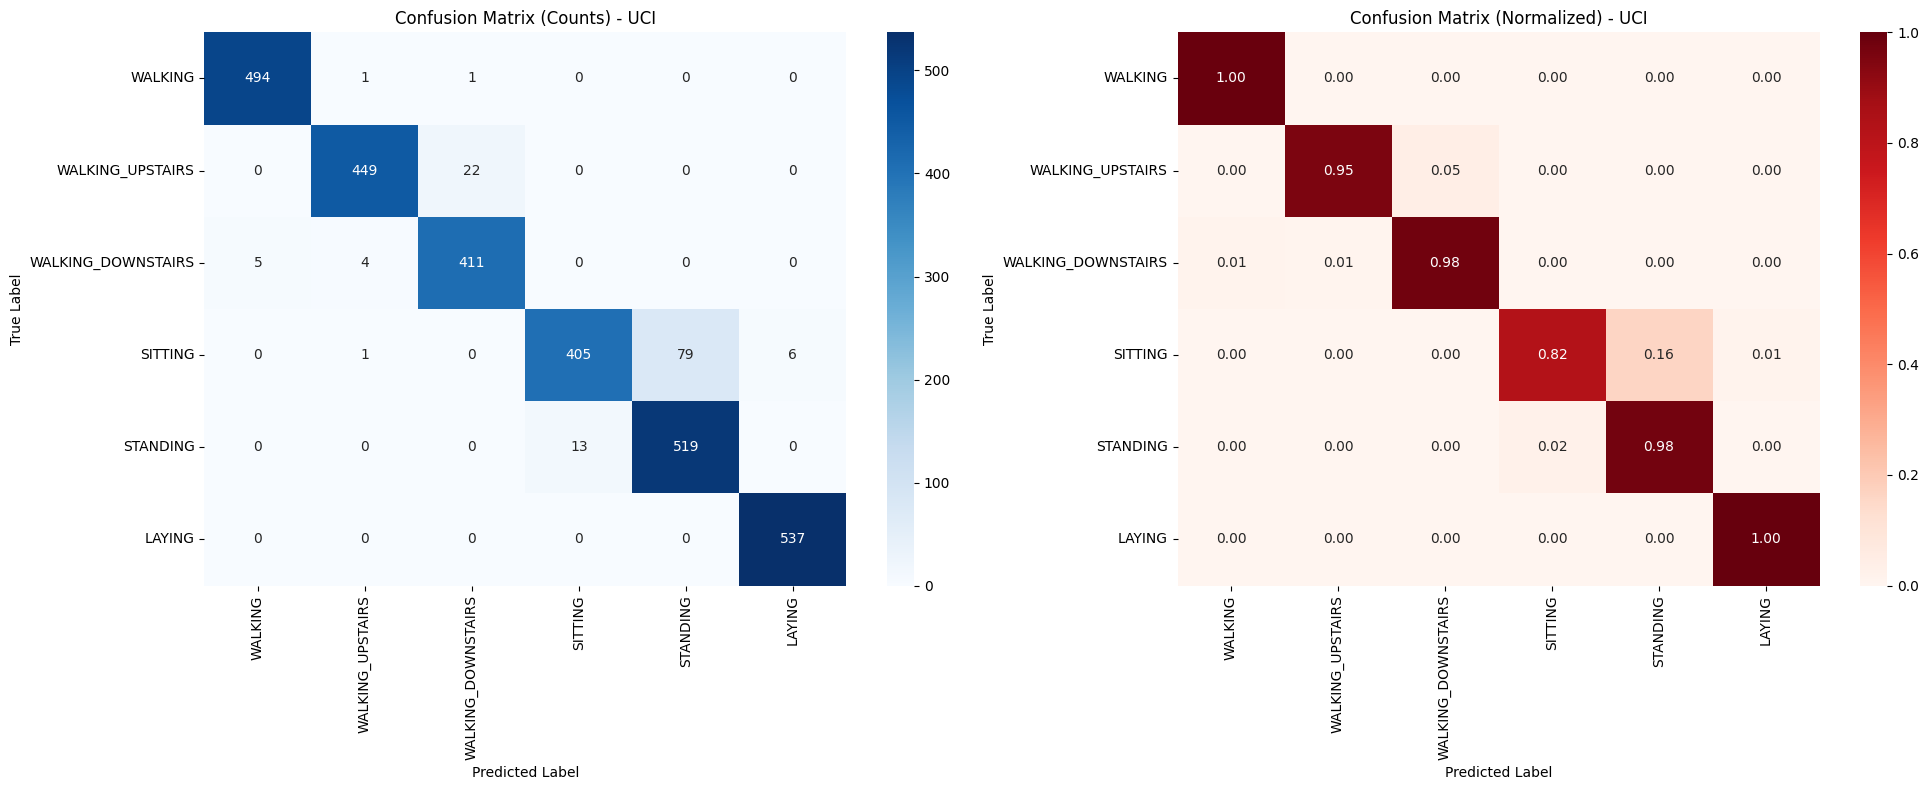

In [20]:
# -----------------------------------------------------------------------------
# [상세 분석 3] Confusion Matrix (Raw & Normalized)
# -----------------------------------------------------------------------------
plt.figure(figsize=(20, 8))

# 3-1. Raw Counts (개수 확인용)
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title(f'Confusion Matrix (Counts) - {TARGET_DATASET}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 3-2. Normalized (비율 확인용 - 헷갈리는 정도 파악)
plt.subplot(1, 2, 2)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.title(f'Confusion Matrix (Normalized) - {TARGET_DATASET}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.savefig(f'{PROJECT_ROOT}/results/figures/cm_{FILE_ID}.png')
print(f"   -> Saved CM plots to: results/figures/cm_{FILE_ID}.png")
plt.show()

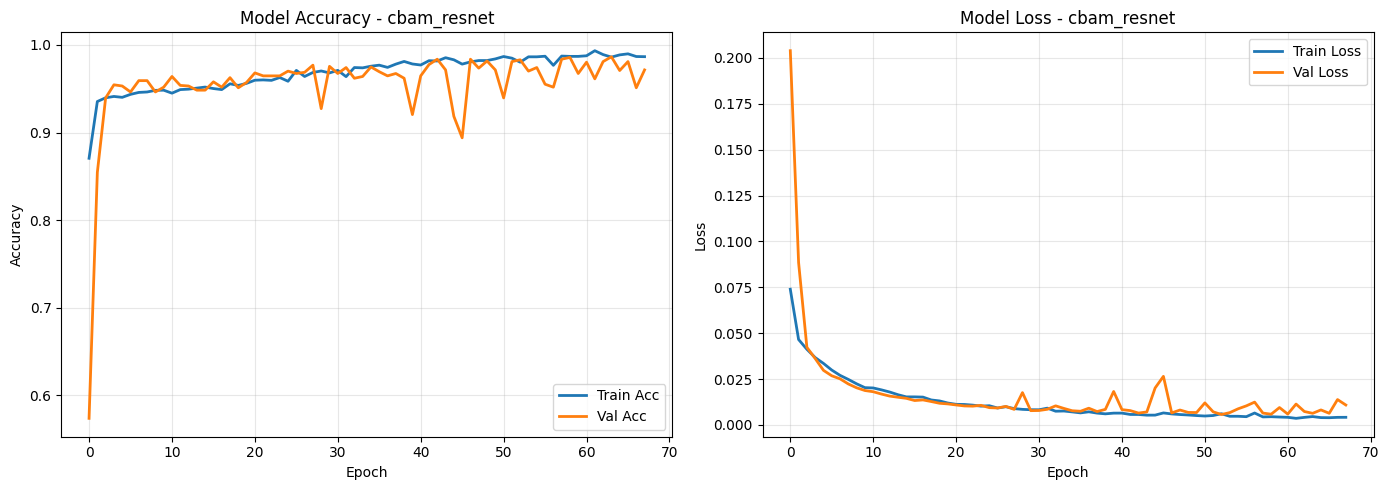

In [21]:
# -----------------------------------------------------------------------------
# [상세 분석 4] 학습 곡선 (Loss & Accuracy)
# -----------------------------------------------------------------------------
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Val Acc', linewidth=2)
plt.title(f'Model Accuracy - {TARGET_MODEL}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.title(f'Model Loss - {TARGET_MODEL}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{PROJECT_ROOT}/results/figures/learning_curve_{FILE_ID}.png')
plt.show()